## Importing packages and data

In [118]:
## Importing packages and data
# Importing libraries
import pandas as pd
import numpy as np

# Configure matplotlib for inline plotting in Jupyter
%matplotlib inline
import matplotlib.pyplot as plt
plt.ion()  # Enable interactive mode
from matplotlib import colors
import seaborn as sns
import matplotlib
matplotlib.use('inline')  # or 'Qt5Agg' depending on your system
import json
import os
from pathlib import Path
import copy

from subprocess import Popen, PIPE, STDOUT
from glob import glob

import langchain  # Main LangChain import
from langchain_openai import ChatOpenAI  # To work with OpenAI
from langchain_anthropic import ChatAnthropic
# from langchain_google_genai import ChatGoogleGenerativeAI # To work with Gemini (optional)
from langchain_core.output_parsers import JsonOutputParser  # To help with structured output
from langchain_core.prompts import PromptTemplate  # To help create our prompt
from langchain_core.pydantic_v1 import BaseModel, Field  # To help with defining what output structure we want
from pydantic import BaseModel

from typing import List, Tuple

from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

from langchain_core.prompts import PromptTemplate
from langchain_core.messages import AIMessage
from langchain.load.dump import dumps
from langchain_core.messages import HumanMessage



import logging
import sys

import ast

In [119]:
# ==========================
# Configure Logging
# ==========================

# Create a logger
logger = logging.getLogger('ReWOO_LangGraph')
logger.setLevel(logging.DEBUG)

# Clear any existing handlers attached to the logger
if logger.hasHandlers():
    logger.handlers.clear()

# Create handlers
c_handler = logging.StreamHandler(sys.stdout)
f_handler = logging.FileHandler('rewoolanggraph.log', mode='w')

c_handler.setLevel(logging.INFO)
f_handler.setLevel(logging.DEBUG)

# Create formatters and add them to handlers
c_format = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
f_format = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
c_handler.setFormatter(c_format)
f_handler.setFormatter(f_format)

# Add handlers to the logger
logger.addHandler(c_handler)
logger.addHandler(f_handler)


In [120]:
# ==========================
# Function to load JSON files
# ==========================

def load_json(filepath):
    with open(filepath, 'r') as file:
        return json.load(file)

In [121]:
# ==========================
# Loading Files
# ==========================

base_path = 'helper_folder/data/challenges/'

# Subset of challenges for testing
subset_ids_challenges = load_json(base_path + '28_8x10_challenges.json')
subset_ids_evaluation = load_json(base_path + '28_15x15_evaluation.json')

# Load evaluation dataset
evaluation_challenges = load_json(base_path + 'arc-agi_evaluation_challenges.json')
evaluation_solutions = load_json(base_path + 'arc-agi_evaluation_solutions.json')

# load training dataset
training_challenges = load_json(base_path + 'arc-agi_training_challenges.json')
training_solutions = load_json(base_path + 'arc-agi_training_solutions.json')

# Filter training challenges and solutions to only include the subset IDs
training_challenges = {k: v for k, v in training_challenges.items() if k in subset_ids_challenges}
training_solutions = {k: v for k, v in training_solutions.items() if k in subset_ids_challenges}

# filter evaluation challenges and solutions to only include the subset IDs
evaluation_challenges = {k: v for k, v in evaluation_challenges.items() if k in subset_ids_evaluation}
evaluation_solutions = {k: v for k, v in evaluation_solutions.items() if k in subset_ids_evaluation}

test_challenges = load_json(base_path + 'arc-agi_test_challenges.json')



task_sets = {
    'training': {
        'challenges': training_challenges,
        'solutions': training_solutions,
    },
    'evaluation': {
        'challenges': evaluation_challenges,
        'solutions': evaluation_solutions,
    }
}

In [122]:
# ==========================
# Function to load tasks from a pre-loaded task set
# ==========================

def load_tasks_from_file(task_set):
    """
    Loads the tasks from the pre-loaded JSON data and returns the challenges and solutions tasks.
    """
    challenges = task_set['challenges']
    solutions = task_set['solutions']

    return challenges, solutions

In [123]:
# ==========================
# Print Dataset Information
# ==========================

print(f'Number of filtered training challenges = {len(training_challenges)}')
print(f'Number of filtered training solutions = {len(training_solutions)}')

# Loading tasks from the 'training' task set
challenges, solutions = load_tasks_from_file(task_set=task_sets['training'])
print(json.dumps(challenges['0520fde7'], indent=2))  # Accessing a specific challenge

Number of filtered training challenges = 28
Number of filtered training solutions = 28
{
  "test": [
    {
      "input": [
        [
          1,
          0,
          1,
          5,
          1,
          0,
          1
        ],
        [
          0,
          1,
          0,
          5,
          1,
          0,
          1
        ],
        [
          1,
          0,
          1,
          5,
          0,
          1,
          0
        ]
      ]
    }
  ],
  "train": [
    {
      "input": [
        [
          1,
          0,
          0,
          5,
          0,
          1,
          0
        ],
        [
          0,
          1,
          0,
          5,
          1,
          1,
          1
        ],
        [
          1,
          0,
          0,
          5,
          0,
          0,
          0
        ]
      ],
      "output": [
        [
          0,
          0,
          0
        ],
        [
          0,
          2,
          0
        ],
        [
  

#### initializing LLM client to use

In [124]:
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv('api.env')

# Get the OpenAI API key from environment variables
openai_api_key = os.getenv('OPENAI_API_KEY')
anthropic_api_key =os.getenv('ANTHROPIC_API_KEY')

# MORE EXPENSIVE MODELS
#llm_openai = ChatOpenAI(model='gpt-4o', openai_api_key=openai_api_key, max_tokens=3000)
#llm_anthropic = ChatAnthropic(model='claude-3-5-sonnet-20241022', anthropic_api_key=anthropic_api_key, max_tokens=3000)

# CHEAPER MODELS
llm_openai = ChatOpenAI(model='gpt-4o-mini', openai_api_key=openai_api_key, max_tokens=3000)
llm_anthropic = ChatAnthropic(model='claude-3-haiku-20240307', anthropic_api_key=anthropic_api_key, max_tokens=3000)

## And incase you want to try Anthropic
# llm = ChatAnthropic(model='claude-3-5-sonnet-20240620', api_key=UserSecretsClient().get_secret("ANTHROPIC_API_KEY"), max_tokens=3000)
# llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro", google_api_key=UserSecretsClient().get_secret("GOOGLE_API_KEY"), max_tokens=3000)

### Function for visualizing the tasks

In [125]:
# ==========================
# Functions to visualize tasks
# ==========================

cmap = colors.ListedColormap(
   ['#000000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
    '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25', '#FFFFFF'])
norm = colors.Normalize(vmin=0, vmax=10)
# print(norm)

def plot_one(ax, i, task, train_or_test, input_or_output):
    # Check if input_or_output is 'solution' or 'predicted_solution'
    if input_or_output == 'solution':
        input_matrix = task[train_or_test][i]['output']  # Assuming this is the ground truth solution
    elif input_or_output == 'predicted_solution':
        input_matrix = task.get('prediction', [])[i]  # Access the predicted solution from task
    else:
        input_matrix = task[train_or_test][i][input_or_output]

    ax.imshow(input_matrix, cmap=cmap, norm=norm)
    ax.grid(True, which='both', color='lightgrey', linewidth=0.5)
    plt.setp(plt.gcf().get_axes(), xticklabels=[], yticklabels=[])
    ax.set_xticks([x - 0.5 for x in range(1 + len(input_matrix[0]))])     
    ax.set_yticks([x - 0.5 for x in range(1 + len(input_matrix))])
    ax.set_title(f"{train_or_test} {input_or_output}")
    return None

   
def plot_eval(task, text, test_input, predicted_solution, actual_solution):
    """
    Plots a single row with three columns: input, predicted solution, and actual solution.
    """
    try:
        # Convert inputs to numpy arrays if they aren't already
        test_input = np.array(test_input)
        predicted_solution = np.array(predicted_solution)
        actual_solution = np.array(actual_solution)
        
        plt.close('all')  # Close any existing plots
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f'{text}', fontsize=16, fontweight='bold')

        # Plot evaluation input
        axs[0].imshow(test_input, cmap=cmap, norm=norm)
        axs[0].set_title('Evaluation Input')
        axs[0].grid(True, color='lightgrey', linewidth=0.5)
        axs[0].set_xticks([x - 0.5 for x in range(1 + len(test_input[0]))]) 
        axs[0].set_yticks([x - 0.5 for x in range(1 + len(test_input))])

        # Plot model's predicted solution
        axs[1].imshow(predicted_solution, cmap=cmap, norm=norm)
        axs[1].set_title('Model Prediction')
        axs[1].grid(True, color='lightgrey', linewidth=0.5)
        axs[1].set_xticks([x - 0.5 for x in range(1 + len(predicted_solution[0]))]) 
        axs[1].set_yticks([x - 0.5 for x in range(1 + len(predicted_solution))])

        # Plot actual solution
        axs[2].imshow(actual_solution, cmap=cmap, norm=norm)
        axs[2].set_title('Actual Solution')
        axs[2].grid(True, color='lightgrey', linewidth=0.5)
        axs[2].set_xticks([x - 0.5 for x in range(1 + len(actual_solution[0]))]) 
        axs[2].set_yticks([x - 0.5 for x in range(1 + len(actual_solution))])

        # Add value annotations to each cell
        for ax, data in zip(axs, [test_input, predicted_solution, actual_solution]):
            for i in range(len(data)):
                for j in range(len(data[0])):
                    ax.text(j, i, str(data[i][j]), 
                           ha='center', va='center',
                           color='white' if data[i][j] in [0, 1, 9] else 'black')

        plt.tight_layout()
        plt.show()
        plt.close()  # Close the plot after showing it
        
    except Exception as e:
        logger.error(f"Error in plot_eval: {str(e)}")
        plt.close('all')  # Clean up any partial plots
 
def plot_task(task1, text):    
    num_train = len(task1['train'])
    w=num_train
    fig, axs  = plt.subplots(2, w, figsize=(3*w ,3*2))
    plt.suptitle(f'{text}:', fontsize=20, fontweight='bold', y=1)

    for j in range(num_train):     
        plot_one(axs[0, j], j,task1,'train', 'input')
        plot_one(axs[1, j], j,task1,'train', 'output')  
    
    fig.patch.set_linewidth(5)
    fig.patch.set_edgecolor('black') 
    fig.patch.set_facecolor('#dddddd')
    plt.tight_layout()
    # plt.show()
    return plt    
    
def openai_encode_image_base64(plt):
    import io
    plt_stringIObytes = io.BytesIO()
    plt.savefig(plt_stringIObytes, format='png')
    plt_stringIObytes.seek(0)
    base64_image = base64.b64encode(plt_stringIObytes.read()).decode('utf-8')
    return {
      "type": "image_url",
      "image_url": {
        "url": f"data:image/jpeg;base64,{base64_image}"
      }
    }

## Trying to make MVP product which is just regular openai model trying to predict 

In [126]:
# converting train and test pairs to a string format ideal for LLMs
def json_task_to_string(challenge_tasks: dict, task_id: str, test_input_index: int) -> str:
    """
    challenge_tasks: dict a list of tasks
    task_id: str the id of the task we want to convert to a string
    
    Convert your json task into a string so you can pass it to your LLM.
    This is a crucial step where you can use your creativity to edit how tasks are represented.
    """
    json_task = challenge_tasks[task_id]

    final_output = ""

    train_tasks = json_task['train']
    test_task = json_task['test']

    final_output = "Training Examples\n"

    for i, task in enumerate(train_tasks):
        final_output += f"Example {i + 1}: Input\n["
        for row in task['input']:
            final_output += f"\n{str(row)},"

        final_output += "]\n\n"
        final_output += f"Example {i + 1}: Output\n["

        for row in task['output']:
            final_output += f"\n{str(row)},"

        final_output += "]\n\n"

    final_output += "Test\n["
    for row in test_task[test_input_index]['input']:
        final_output += f"\n{str(row)}"

    final_output += "]\n\nYour Response:"

    return final_output

In [127]:
# an example of how the function works
task_string = json_task_to_string(challenges, '0520fde7', 0)
print (task_string)

Training Examples
Example 1: Input
[
[1, 0, 0, 5, 0, 1, 0],
[0, 1, 0, 5, 1, 1, 1],
[1, 0, 0, 5, 0, 0, 0],]

Example 1: Output
[
[0, 0, 0],
[0, 2, 0],
[0, 0, 0],]

Example 2: Input
[
[1, 1, 0, 5, 0, 1, 0],
[0, 0, 1, 5, 1, 1, 1],
[1, 1, 0, 5, 0, 1, 0],]

Example 2: Output
[
[0, 2, 0],
[0, 0, 2],
[0, 2, 0],]

Example 3: Input
[
[0, 0, 1, 5, 0, 0, 0],
[1, 1, 0, 5, 1, 0, 1],
[0, 1, 1, 5, 1, 0, 1],]

Example 3: Output
[
[0, 0, 0],
[2, 0, 0],
[0, 0, 2],]

Test
[
[1, 0, 1, 5, 1, 0, 1]
[0, 1, 0, 5, 1, 0, 1]
[1, 0, 1, 5, 0, 1, 0]]

Your Response:


In [128]:
# Using a json output parser to parse the output, since LLMs aren't perfect at generating valid json
# Defining a prediction as a list of lists
class ARCPrediction(BaseModel):
    prediction: List[List] = Field(..., description="A prediction for a task")

## Setting up langgraph for mUlTiaGenTiC sYstEM

In [129]:
# Setting up the state for the graph
class State(TypedDict):
    messages: Annotated[list, add_messages]
    patterns: Annotated[list, add_messages]
    code: str
    prediction: List[List]
    task_string: str
    task_data: dict
    test_input_index: int
    predicted_grid_size: str  # Add this line



In [130]:
# Utility functions for objects
def get_size(grid):
    ''' Returns the size of the grid in 2 axis '''
    return (len(grid), len(grid[0]))

def get_middle(coords):
    ''' Returns the middle of the coordinates '''
    x_sum, y_sum = 0, 0
    for (x, y) in coords:
        x_sum += int(x)
        y_sum += int(y)
    return (int(x_sum / len(coords) + 0.5), int(y_sum / len(coords) + 0.5))

def get_anchor(coords):
    ''' Returns the top left, and bottom right anchor of the shape '''
    min_x, min_y = 10000, 10000
    max_x, max_y = 0, 0
    for (x, y) in coords:
        min_x = min(x, min_x)
        min_y = min(y, min_y)
        max_x = max(x, max_x)
        max_y = max(y, max_y)
    return (min_x, min_y), (max_x, max_y)

def get_pixel_coords(grid):
    ''' Gets the coordinates of all pixel values '''
    pixel_coord = {}
    for row in range(len(grid)):
        for col in range(len(grid[0])):
            value = grid[row][col]
            if value != 0:  # We assume '0' or '.' is empty space
                if value in pixel_coord:
                    pixel_coord[value].append((row, col))
                else:
                    pixel_coord[value] = [(row, col)]
    return dict(sorted(pixel_coord.items(), key=lambda x: -len(x[1])))

def obj_to_coords(obj):
    coords = []
    x, y = obj['tl']
    height, width = len(obj['grid']), len(obj['grid'][0])
    for i in range(height):
        for j in range(width):
            if obj['grid'][i][j] != 0:
                coords.append((x + i, y + j))
    return coords

def create_object(grid, coords):
    ''' Create an object based on the existing grid and the coordinates of it '''
    (min_x, min_y), (max_x, max_y) = get_anchor(coords)
    newgrid = [[0 for _ in range(max_y - min_y + 1)] for _ in range(max_x - min_x + 1)]
    for (x, y) in coords:
        if grid[x][y] == 0:
            newgrid[x - min_x][y - min_y] = -1  # Indicate empty spot with -1
        else:
            newgrid[x - min_x][y - min_y] = grid[x][y]
    return {'tl': (min_x, min_y), 'grid': newgrid}

# Test case
assert get_pixel_coords([[1, 1], [4, 6]]) == {1: [(0, 0), (0, 1)], 4: [(1, 0)], 6: [(1, 1)]}

def get_objects(grid, diag=False, multicolor=False, by_row=False, by_col=False, by_color=False, more_info=True):
    rows = len(grid)
    cols = len(grid[0])
    visited = set()
    objects = []
    missing_color = False

    # Check whether there is a missing color (using '10' to denote missing color)
    for each in grid:
        for cell in each:
            if cell == 10:
                missing_color = True

    def is_valid(grid, row, col, value):
        # Multicolor can return any cell as long as it is not visited and not a blank
        if multicolor:
            return 0 <= row < rows and 0 <= col < cols and (row, col) not in visited and grid[row][col] != 0
        else:  
            return 0 <= row < rows and 0 <= col < cols and (row, col) not in visited and grid[row][col] == value

    def dfs(grid, row, col, value):
        if is_valid(grid, row, col, value):
            visited.add((row, col))
            object_coords.add((row, col))

            if not by_row:
                dfs(grid, row - 1, col, value)  # up
                dfs(grid, row + 1, col, value)  # down
            if not by_col:
                dfs(grid, row, col - 1, value)  # left
                dfs(grid, row, col + 1, value)  # right
            if not by_row and not by_col and diag:
                dfs(grid, row - 1, col - 1, value)  # top-left diagonal
                dfs(grid, row - 1, col + 1, value)  # top-right diagonal
                dfs(grid, row + 1, col - 1, value)  # bottom-left diagonal
                dfs(grid, row + 1, col + 1, value)  # bottom-right diagonal

    # If by_color, we don't need to do DFS
    if by_color:
        pixels = get_pixel_coords(grid)
        for key, value in pixels.items():
            object_coords = value
            object_dict = create_object(grid, object_coords)
            if more_info:
                object_dict['size'] = (len(object_dict['grid']), len(object_dict['grid'][0]))
                object_dict['cell_count'] = len(object_coords)
                object_dict['shape'] = [[1 if cell != 0 else 0 for cell in row] for row in object_dict['grid']]
            objects.append(object_dict)
            
    else:
        for row in range(rows):
            for col in range(cols):
                value = grid[row][col]
                if (row, col) not in visited:
                    if value == 0: continue
                    object_coords = set()
                    dfs(grid, row, col, value)
                    object_dict = create_object(grid, object_coords)
                    if more_info:
                        object_dict['size'] = (len(object_dict['grid']), len(object_dict['grid'][0]))
                        object_dict['cell_count'] = len(object_coords)
                        object_dict['shape'] = [[1 if cell != 0 else 0 for cell in row] for row in object_dict['grid']]
                    objects.append(object_dict)

        # If there's no color '10', perform additional processing for inner objects
        if not missing_color:
            multicolor = False
            new_objects = []
            for obj in objects:
                visited = set()
                newgrid = obj['grid']
                rows = len(newgrid)
                cols = len(newgrid[0])
                for row in range(rows):
                    for col in range(cols):
                        if (row, col) not in visited:
                            if newgrid[row][col] == 0:
                                object_coords = set()
                                dfs(newgrid, row, col, 0)
                                boundary = False
                                for x, y in object_coords:
                                    if x == 0 or x == len(newgrid) - 1 or y == 0 or y == len(newgrid[0]) - 1:
                                        boundary = True
                                if boundary: continue
                                object_dict = create_object(newgrid, object_coords)
                                cur_x, cur_y = object_dict['tl']
                                base_x, base_y = obj['tl']
                                object_dict['tl'] = (cur_x + base_x, cur_y + base_y)
                                if more_info:
                                    object_dict['size'] = (len(object_dict['grid']), len(object_dict['grid'][0]))
                                    object_dict['cell_count'] = len(object_coords)
                                    object_dict['shape'] = [[1 if cell != 0 else 0 for cell in row] for row in object_dict['grid']]
                                new_objects.append(object_dict)
            objects.extend(new_objects)
    return objects

def combine_object(obj1, obj2):
    # if not an instance of object, create it
    if not isinstance(obj1, dict): obj1 = {'tl': (0, 0), 'grid': obj1}
    if not isinstance(obj2, dict): obj2 = {'tl': (0, 0), 'grid': obj2}
    grid = empty_grid(30, 30)
    grid = fill_grid(grid, obj1['tl'], obj1['grid'])
    grid = fill_grid(grid, obj2['tl'], obj2['grid'])
    obj_coords = obj_to_coords(obj1)
    obj_coords2 = obj_to_coords(obj2)
    obj_coords.extend(obj_coords2)
    return create_object(grid, obj_coords)

def tight_fit(grid):
    objects = get_objects(grid)
    obj = objects[0]
    for each in objects[1:]:
        obj = combine_object(obj, each)
    return obj['grid']

def fill_grid(grid, tl, pattern):
    x, y = tl
    if not isinstance(pattern, list): pattern = [[pattern]]
    for row in range(len(pattern)):
        for col in range(len(pattern[0])):
            if 0 <= row + x < len(grid) and 0 <= col + y < len(grid[0]): 
                if pattern[row][col] != -1:
                    grid[row + x][col + y] = pattern[row][col]
    return grid

def fill_object(grid, obj, align=False):
    if align: return obj['grid']
    return fill_grid(grid, obj['tl'], obj['grid'])

def empty_grid(row, col):
    return [[0 for _ in range(col)] for _ in range(row)]

def crop_grid(grid, tl, br): 
    return [[grid[i][j] for j in range(tl[1], br[1] + 1)] for i in range(tl[0], br[0] + 1)]

def fill_between_coords(grid, coord1, coord2, value): 
    # fill up a point
    if coord1 == coord2:
        grid[coord1[0]][coord1[1]] = value
        return grid
    
    # fill up a line
    row_diff = coord1[0] - coord2[0]
    col_diff = coord1[1] - coord2[1]
    maxdist = max(abs(row_diff), abs(col_diff))
    height, width = len(grid), len(grid[0])
    for i in range(maxdist + 1):
        row_pos, col_pos = coord1[0] - (i * row_diff) // maxdist, coord1[1] - (i * col_diff) // maxdist
        if 0 <= row_pos < height and 0 <= col_pos < width:
            grid[row_pos][col_pos] = value
    return grid

def rotate_clockwise(grid, degree=90):
    newgrid = copy.deepcopy(grid)
    for i in range(degree // 90):
        # Transpose the array
        transposed_grid = [[newgrid[j][i] for j in range(len(newgrid))] for i in range(len(newgrid[0]))]

        # Reverse each row of the transposed array
        newgrid = [row[::-1] for row in transposed_grid]
    return newgrid

def horizontal_flip(grid):
    return [row[::-1] for row in grid]

def vertical_flip(grid):
    return [row for row in grid[::-1]]

def fill_value(grid, pos, value):
    x, y = pos
    if x < 0 or x >= len(grid) or y < 0 or y >= len(grid[0]): return grid
    grid[x][y] = value
    return grid

def replace(grid, pattern1, pattern2):
    if not isinstance(pattern1, list): pattern1 = [[pattern1]]
    if not isinstance(pattern2, list): pattern2 = [[pattern2]]
    height, width = len(pattern1), len(pattern1[0])
    for i in range(len(grid) - height + 1):
        for j in range(len(grid[0]) - width + 1):
            if crop_grid(grid, (i, j), (i + height - 1, j + width - 1)) == pattern1:
                grid = fill_grid(grid, (i, j), pattern2)
    return grid

def fill_rect(grid, tl, br, value):
    for row in range(tl[0], br[0] + 1):
        for col in range(tl[1], br[1] + 1):
            grid = fill_value(grid, (row, col), value)
    return grid

def fill_row(grid, row_num, value, start_col=0, end_col=30):
    for col_num in range(start_col, end_col + 1):
        grid = fill_value(grid, (row_num, col_num), value)
    return grid

def fill_col(grid, col_num, value, start_row=0, end_row=30): 
    for row_num in range(start_row, end_row + 1):
        grid = fill_value(grid, (row_num, col_num), value)
    return grid

def change_object_pos(obj, new_tl):
    obj['tl'] = new_tl
    return obj

def change_object_color(obj, value):
    for row in range(len(obj['grid'])):
        for col in range(len(obj['grid'][0])):
            if obj['grid'][row][col] != 0:
                obj['grid'][row][col] = value
    return obj

def get_object_color(obj):
    for row in range(len(obj['grid'])):
        for col in range(len(obj['grid'][0])):
            if obj['grid'][row][col] != 0:
                return obj['grid'][row][col]
    return 0



helper_functions = '''- get_objects(grid, diag=False, by_row=False, by_col=False, by_color=False, multicolor=False, more_info=True): 
Takes in grid, returns list of object dictionary: top-left coordinate of object ('tl'), 2D grid ('grid')
by_row views splits objects by grid rows, by_col splits objects by grid columns, by_color groups each color as one object, multicolor means object can be more than one color
Empty cells within objects are represented as -1
If more_info is True, also returns size of grid ('size'), cells in object ('cell_count'), shape of object ('shape')
- get_pixel_coords(grid): Returns a dictionary, with the keys the pixel values, values the list of coords, in sorted order from most number of pixels to least
- empty_grid(row, col): returns an empty grid of height row and width col
- crop_grid(grid, tl, br): returns cropped section from top left to bottom right of the grid
- tight_fit(grid): returns grid with all blank rows and columns removed
- combine_object(obj_1, obj_2): returns combined object from obj_1 and obj_2. if overlap, obj_2 overwrites obj_1
- rotate_clockwise(grid, degree=90): returns rotated grid clockwise by a degree of 90, 180, 270 degrees
- horizontal_flip(grid): returns a horizontal flip of the grid
- vertical_flip(grid): returns a vertical flip of the grid
- replace(grid, grid_1, grid_2): replaces all occurrences of grid_1 with grid_2 in grid
- get_object_color(obj): returns color of object. if multicolor, returns first color only
- change_object_color(obj, value): changes the object color to value
- fill_object(grid, obj, align=False): fills grid with object. If align is True, makes grid same size as object
- fill_row(grid, row_num, value, start_col=0, end_col=30): fills output grid with a row of value at row_num from start_col to end_col (inclusive)
- fill_col(grid, col_num, value, start_row=0, end_row=30): fills output grid with a column of value at col_num from start_row to end_row (inclusive)
- fill_between_coords(grid, coord_1, coord_2, value): fills line between coord_1 and coord_2 with value
- fill_rect(grid, tl, br, value): fills grid from tl to br with value. useful to create rows, columns, rectangles
- fill_value(grid, pos, value): fills grid at position with value
'''

# Assertions updated to use integer representations (0 for empty cells, -1 for placeholders)
assert get_objects([[1, 1, 1], [1, 0, 1], [1, 1, 1]], more_info=False) == [{'tl': (0, 0), 'grid': [[1, 1, 1], [1, 0, 1], [1, 1, 1]]}, {'tl': (1, 1), 'grid': [[-1]]}]
assert get_pixel_coords([[1, 1], [4, 6]]) == {1: [(0, 0), (0, 1)], 4: [(1, 0)], 6: [(1, 1)]}
assert empty_grid(3, 2) == [[0, 0], [0, 0], [0, 0]]
assert crop_grid([[1, 1, 2], [0, 1, 2]], (0, 0), (1, 1)) == [[1, 1], [0, 1]]
assert tight_fit([[0, 0, 0], [0, 1, 0], [0, 0, 0]]) == [[1]]
assert combine_object({'tl': (0, 0), 'grid': [[1, 1], [1, 0]]}, {'tl': (1, 1), 'grid': [[6]]}) == {'tl': (0, 0), 'grid': [[1, 1], [1, 6]]}
assert rotate_clockwise([[1, 2], [4, 5]], 90) == [[4, 1], [5, 2]]
assert rotate_clockwise([[1, 2], [4, 5]], 270) == [[2, 5], [1, 4]]
assert horizontal_flip([[1, 2, 3], [4, 5, 6]]) == [[3, 2, 1], [6, 5, 4]]
assert vertical_flip([[1, 2, 3], [4, 5, 6]]) == [[4, 5, 6], [1, 2, 3]]
assert replace([[1, 0], [1, 1]], [[1, 1]], [[3, 3]]) == [[1, 0], [3, 3]]
assert change_object_color({'tl': (0, 0), 'grid': [[1, 0]]}, 2) == {'tl': (0, 0), 'grid': [[2, 0]]}
assert get_object_color({'tl': (0, 0), 'grid': [[1, 0]]}) == 1
assert fill_object([[0, 0], [0, 0]], {'tl': (0, 1), 'grid': [[3], [3]]}) == [[0, 3], [0, 3]]
assert fill_value([[0, 1], [0, 1]], (1, 1), 2) == [[0, 1], [0, 2]]
assert fill_row([[1, 1], [3, 1]], 0, 2) == [[2, 2], [3, 1]]
assert fill_col([[1, 1], [3, 1]], 0, 2) == [[2, 1], [2, 1]]
assert fill_rect([[1, 1], [3, 1]], (0, 0), (1, 1), 2) == [[2, 2], [2, 2]]
assert fill_between_coords([[0, 0]], (0, 0), (0, 1), 1) == [[1, 1]]

## Conditional Functions

def object_contains_color(obj, value):
    for row in range(len(obj['grid'])):
        for col in range(len(obj['grid'][0])):
            if obj['grid'][row][col] == value:
                return True
    return False

def on_same_line(coord1, coord2, line_type):
    '''Returns True/False if coord1 is on the same line as coord2. line_type can be one of ['row', 'col', 'diag']'''
    if line_type == 'row': return coord1[0] == coord2[0]
    if line_type == 'col': return coord1[1] == coord2[1]
    if line_type == 'diag': return coord1[0]-coord2[0] == coord1[1]-coord2[1]
    return False
conditional_functions = '''
object_contains_color(obj, value): returns True/False if object contains a certain value
on_same_line(coord_1, coord_2): Returns True/False if coord_1 is on the same line as coord_2. line_type can be one of ['row', 'col', 'diag']
'''

assert object_contains_color({'tl':(0,0),'grid':[['a']]},'a')==True
assert on_same_line((1,1),(1,2),'row')==True
assert on_same_line((1,1),(2,1),'col')==True
assert on_same_line((1,1),(2,2),'diag')==True

#### Generating nodes

In [131]:
# Building nodes for the graph
# first initialize the StateGraph
graph_builder = StateGraph(State)
import ast

# ==========================
# Function to get the grid size prediction. Has 86% accuracy on the training set.
# ==========================
def predict_task_grid_size(train_inputs, train_outputs, test_inputs):
    """
    Predicts the grid size of test inputs based on patterns from the train inputs and outputs.

    Args:
    - train_inputs: List of 2D arrays representing the input grids for training.
    - train_outputs: List of 2D arrays representing the output grids for training.
    - test_inputs: List of 2D arrays representing the input grids for testing.

    Returns:
    - pred_test_sizes: List of predicted sizes for the test outputs in 'WxH' format (e.g., '6x6').
    """

    # Calculate the sizes of train inputs and outputs
    train_in_size = [[len(i[0]), len(i)] for i in train_inputs]
    train_out_size = [[len(i[0]), len(i)] for i in train_outputs]

    # Calculate the sizes of test inputs
    test_in_size = [[len(i[0]), len(i)] for i in test_inputs]

    # Try to detect consistent ratio patterns
    ratio_x = train_in_size[0][0] / train_out_size[0][0]
    ratio_y = train_in_size[0][1] / train_out_size[0][1]

    # Check for consistent ratios in the training set
    for in_size, out_size in zip(train_in_size[1:], train_out_size[1:]):
        if in_size[0] / out_size[0] != ratio_x or in_size[1] / out_size[1] != ratio_y:
            break
    else:
        # If the ratio holds, predict based on the ratio
        pred_test_sizes = [f"{int(i[0] / ratio_x)}x{int(i[1] / ratio_y)}" for i in test_in_size]
        return pred_test_sizes

    # If ratio-based prediction fails, check for consistent subtraction patterns
    sub_x = train_in_size[0][0] - train_out_size[0][0]
    sub_y = train_in_size[0][1] - train_out_size[0][1]

    for in_size, out_size in zip(train_in_size[1:], train_out_size[1:]):
        if in_size[0] - out_size[0] != sub_x or in_size[1] - out_size[1] != sub_y:
            break
    else:
        # If subtraction holds, predict based on subtraction
        pred_test_sizes = [f"{i[0] - sub_x}x{i[1] - sub_y}" for i in test_in_size if i[0] - sub_x > 0 and i[1] - sub_y > 0]
        return pred_test_sizes

    # If subtraction-based prediction fails, predict based on the size of the last output grid
    last_x = train_out_size[0][0]
    last_y = train_out_size[0][1]

    for in_size, out_size in zip(train_in_size[1:], train_out_size[1:]):
        if out_size[0] != last_x or out_size[1] != last_y:
            break
    else:
        # If all output grids are the same size, predict this size for all test inputs
        pred_test_sizes = [f"{last_x}x{last_y}" for _ in test_in_size]
        return pred_test_sizes

    # If no pattern holds, return 'Unknown' indicating an unknown prediction
    pred_test_sizes = ['Unknown' for _ in test_in_size]
    return pred_test_sizes



# ==========================
# Helper Function to Convert Messages
# ==========================

def convert_messages(message_list):
    return [
        msg.content if isinstance(msg, (AIMessage, HumanMessage)) else str(msg)
        for msg in message_list
    ]

def make_serializable(obj):
    if isinstance(obj, (AIMessage, HumanMessage)):
        return obj.content
    elif isinstance(obj, list):
        return [make_serializable(item) for item in obj]
    elif isinstance(obj, dict):
        return {key: make_serializable(value) for key, value in obj.items()}
    else:
        return obj  # Assume the object is already serializable

# ==========================
# execute_code with Syntax Checking and Logging
# ==========================

def execute_code(state: State):
    code = state['code']
    task_data = state['task_data']

    test_input_index = state['test_input_index']
    test_input = task_data['test'][test_input_index]['input']

    # Log the code for debugging
    logger.debug(f"Executing code:\n{code}")

    # Syntax check
    try:
        ast.parse(code)
    except SyntaxError as se:
        logger.error(f"Syntax error in generated code: {se.text}\n"
                     f"Error at line {se.lineno}, column {se.offset}\n"
                     f"Line content: {se.text}")
        return {"prediction": [], "revised_code": code}

    local_vars = {}
    global_vars = {}

    try:
        exec(code, global_vars, local_vars)
        if 'solve_task' in local_vars:
            solve_task = local_vars['solve_task']
        elif 'solve_task' in global_vars:
            solve_task = global_vars['solve_task']
        else:
            raise Exception("solve_task function not defined in code.")

        prediction = solve_task(test_input)
    except Exception as e:
        prediction = []
        logger.error(f"Error executing code: {e}")

    return {"prediction": prediction, "revised_code": code}

# ==========================
# generate_code with Enhanced Prompt
# ==========================

import re  # Import this at the top of your file to use regex for stripping

def clean_code_output(code: str) -> str:
    """
    Function to clean up the code generated by the LLM.
    Strips out markdown-like syntax like ```python and ```.
    """
    # Use regex to remove markdown code block markers and unnecessary spaces
    cleaned_code = re.sub(r'```[\w]*', '', code).strip()
    return cleaned_code

def generate_code(state: State):
    patterns = state['patterns'][-1]  # Get the last patterns added

    prompt = PromptTemplate(
        template=(
            "You are an expert Python programmer.\n\n"
            "Given the following patterns, write Python code that solves the task according to these patterns.\n"
            "The code should define a function `solve_task(input_grid)` that returns the output grid.\n"
            "Ensure the code is syntactically correct and free of any errors.\n\n"
            "**ONLY** return the code without any additional explanations.\n\n"
            "Patterns:\n{patterns}\n\n"
            "Your code:"
        ),
        input_variables=["patterns"]
    )

    chain = prompt | llm_anthropic
    code = chain.invoke({"patterns": patterns}).content.strip()

    # Clean up the generated code by removing any markdown formatting
    cleaned_code = clean_code_output(code)

    return {"code": cleaned_code}

def revise_code(state: State):
    code = state['code']

    prompt = PromptTemplate(
        template=(
            "Review the following Python code and improve it if necessary.\n"
            "Ensure that it correctly implements the desired functionality and handles edge cases.\n\n"
            "**ONLY** return the revised code without any explanations or comments.\n\n"
            "Code:\n{code}\n\n"
            "Revised code:"
        ),
        input_variables=["code"]
    )

    chain = prompt | llm_anthropic
    revised_code = chain.invoke({"code": code}).content.strip()

    # Clean up the revised code by removing any markdown formatting
    cleaned_revised_code = clean_code_output(revised_code)

    return {"code": cleaned_revised_code}


# ==========================
# identify_logic Function
# ==========================

def identify_logic(state: State):
    task_string = state['task_string']
    predicted_grid_size = state.get('predicted_grid_size')
    
    logger.info(f"Identifying logic for task: {task_string} with predicted grid size: {predicted_grid_size}")
    prompt = PromptTemplate(
        template=(
            "You are an AI assistant specializing in puzzle solving.\n\n"
            "The predicted grid size for this task is {predicted_grid_size}.\n"
            "Given the following task, identify the logic or pattern present in the training examples.\n"
            "Provide a brief description of the logic in bullet points.\n\n"
            "Task:\n{task_string}\n\n"
            "Your response should be a brief description of the logic."
        ),
        input_variables=["task_string", "predicted_grid_size"]
    )

    chain = prompt | llm_openai
    output = chain.invoke({
        "task_string": task_string,
        "predicted_grid_size": predicted_grid_size
    }).content

    # Return both the AIMessage and the predicted_grid_size
    return {
        "messages": [AIMessage(content=output)],
        "predicted_grid_size": predicted_grid_size  # Include this in the return
    }


# ==========================
# recognize_patterns Function
# ==========================

def recognize_patterns(state: State):
    messages = state['messages']
    previous_analysis = messages[-1]  # Already converted to string in get_task_prediction

    prompt = PromptTemplate(
        template=(
            "Based on the previous analysis, identify detailed patterns in the task.\n"
            "Focus on visual patterns, JSON structures, or any other relevant aspects.\n"
            "Provide the patterns as a list of concise statements.\n\n"
            "Previous analysis:\n{previous_analysis}\n\n"
            "Your response should be a list of patterns."
        ),
        input_variables=["previous_analysis"]
    )

    chain = prompt | llm_openai
    output = chain.invoke({"previous_analysis": previous_analysis}).content

    return {"patterns": [output]}


#### Building the graph with eches

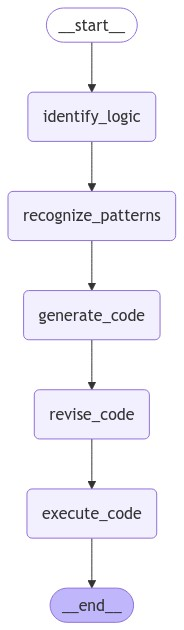

In [132]:
graph_builder.add_node("identify_logic", identify_logic)
graph_builder.add_node("recognize_patterns", recognize_patterns)
graph_builder.add_node("generate_code", generate_code)
graph_builder.add_node("revise_code", revise_code)
graph_builder.add_node("execute_code", execute_code)

graph_builder.add_edge(START, "identify_logic")
graph_builder.add_edge("identify_logic", "recognize_patterns")
graph_builder.add_edge("recognize_patterns", "generate_code")
graph_builder.add_edge("generate_code", "revise_code")
graph_builder.add_edge("revise_code", "execute_code")
graph_builder.add_edge("execute_code", END)

graph = graph_builder.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Creating function to get task prediction, make prompt, make API calls to model and parse output with retries

In [133]:
def get_task_prediction(challenge_tasks, solutions, task_id, test_input_index, plot=False):
    task_string = json_task_to_string(challenge_tasks, task_id, test_input_index)
    task_data = challenge_tasks[task_id]
    
    train_tasks = task_data['train']
    train_inputs = [t['input'] for t in train_tasks]
    train_outputs = [t['output'] for t in train_tasks]
    test_input = task_data['test'][test_input_index]['input']
    
    # Ensure you have the actual solution
    actual_solution = solutions.get(task_id, [])[test_input_index]
    
    # Predict the grid size
    predicted_grid_size = predict_task_grid_size(train_inputs, train_outputs, [test_input])[0]

    initial_state = {
        'task_string': task_string,
        'task_data': task_data,
        'test_input_index': test_input_index,
        'predicted_grid_size': predicted_grid_size,
        'messages': [],
        'patterns': [],
        'code': '',
        'revised_code': '',
        'prediction': []
    }

    # Invoke the graph or prediction model
    final_state = graph.invoke(initial_state)
    predicted_solution = final_state.get('prediction', [])

    # Add debugging print statements
    if plot:
        try:
            print("Debug - Plotting dimensions:")
            print(f"Test input shape: {np.array(test_input).shape}")
            print(f"Predicted solution shape: {np.array(predicted_solution).shape}")
            print(f"Actual solution shape: {np.array(actual_solution).shape}")
            
            # Only plot if we have valid arrays
            if len(predicted_solution) > 0:
                logger.info(f"Plotting results for task {task_id}, attempt {test_input_index}")
                plot_eval(task_data, f"Task {task_id} Attempt", test_input, predicted_solution, actual_solution)
            else:
                logger.warning("Skipping plot - predicted solution is empty")
        except Exception as e:
            logger.error(f"Error during plotting: {str(e)}")
            plt.close('all')  # Clean up any partial plots

    # Extract messages and return structured output
    messages = final_state.get('messages', [])
    if messages:
        messages = [msg.content if isinstance(msg, AIMessage) else msg for msg in messages]

    output_details = {
        'messages': messages,
        'patterns': final_state.get('patterns', []),
        'code': final_state.get('code', ''),
        'revised_code': final_state.get('revised_code', ''),
        'prediction': predicted_solution
    }

    return output_details

In [134]:
def make_serializable(obj):
    if isinstance(obj, (AIMessage, HumanMessage)):
        return obj.content
    elif isinstance(obj, list):
        return [make_serializable(item) for item in obj]
    elif isinstance(obj, dict):
        return {key: make_serializable(value) for key, value in obj.items()}
    else:
        return obj  # Assume the object is already serializable

def run_model(challenges, solutions, NUM_ATTEMPTS=2, RETRY_ATTEMPTS=3, NUM_TASKS=None):
    submission = {}
    detailed_outputs = {}

    for i, task_id in enumerate(challenges):
        task_attempts = []
        detailed_outputs[task_id] = []

        # Iterate through each test pair for a prediction
        for t, pair in enumerate(challenges[task_id]['test']):
            logger.info(f"Starting task #{i + 1} ({task_id}), pair #{t+1}")

            # Get the predicted grid size
            train_tasks = challenges[task_id]['train']
            train_inputs = [t['input'] for t in train_tasks]
            train_outputs = [t['output'] for t in train_tasks]
            test_input = challenges[task_id]['test'][t]['input']
            predicted_grid_size = predict_task_grid_size(train_inputs, train_outputs, [test_input])[0]

            pair_attempts = {}
            pair_detailed = {
                'predicted_grid_size': predicted_grid_size  # Add the predicted grid size here
            }

            # Make attempts with retries
            for attempt in range(1, NUM_ATTEMPTS + 1):
                attempt_key = f"attempt_{attempt}"
                pair_attempts[attempt_key] = []
                pair_detailed[attempt_key] = {
                    'predicted_grid_size': predicted_grid_size  # Add it to each attempt as well
                }

                # Run retries within the attempt
                for retry in range(RETRY_ATTEMPTS):
                    # Always plot in notebook
                    should_plot = True
                    logger.info(f"Plot flag for task {task_id}, attempt {attempt}, retry {retry}: {should_plot}")

                    try:
                        prediction_details = get_task_prediction(
                            challenge_tasks=challenges,
                            solutions=solutions,
                            task_id=task_id,
                            test_input_index=t,
                            plot=should_plot
                        )

                        # Print prediction details for debugging
                        print(f"\nPrediction details for {attempt_key}, retry {retry}:")
                        print(f"Prediction: {prediction_details['prediction']}")
                        print(f"Expected solution: {solutions[task_id][t]}")

                        # Store valid prediction and exit retry loop on success
                        if prediction_details['prediction']:  # Only store if we have a prediction
                            pair_attempts[attempt_key] = prediction_details['prediction']
                            pair_detailed[attempt_key] = prediction_details
                            
                            # Check if prediction matches solution
                            if prediction_details['prediction'] == solutions[task_id][t]:
                                print(f"Found correct solution in {attempt_key}, retry {retry}")
                                break
                            
                        break  # Exit retry loop if we got any valid prediction
                    except Exception as e:
                        logger.warning(f"Retrying: {e}")
                        if retry == RETRY_ATTEMPTS - 1:
                            pair_attempts[attempt_key] = []
                            pair_detailed[attempt_key] = {'error': str(e)}

            task_attempts.append(pair_attempts)
            detailed_outputs[task_id].append(pair_detailed)

        submission[task_id] = task_attempts

        if NUM_TASKS is not None and i + 1 == NUM_TASKS:
            break

    # Save detailed outputs
    serializable_outputs = make_serializable(detailed_outputs)
    with open('detailed_outputs.json', 'w') as f:
        json.dump(serializable_outputs, f, indent=2)

    return submission

### Creating submission files and comparing it with solutions file

In [135]:
# create submission file
def create_submission_file(submission, file_name='submission.json'):
    """
    Save a submission file to the specified file name
    """
    with open(file_name, "w") as file:
        json.dump(submission, file)

    print (f"Submission saved to {file_name}")

In [136]:
# create function to compare submission with solutions
def score_submission(submission_file_name, solutions) -> Tuple[float, int]:
    """
    submission_file_name: str, the file name of your submission file
    solutions: dict, the ground truth solutions you'd like to test against
    """
    print(f"Scoring {submission_file_name}\n")

    # Open your submission file
    with open(submission_file_name, "r") as file:
        submission = json.load(file)

    total_score = 0
    total_tasks = 0

    # Add debugging prints
    print("Submission contents:")
    print(json.dumps(submission, indent=2))
    print("\nSolutions contents:")
    print(json.dumps(solutions, indent=2))

    # Loop through each task in your submission to grade it
    for task_id, task_submission in submission.items():
        total_tasks += 1
        task_score = 0
        num_pairs = len(task_submission)

        print(f"\nScoring task {task_id}:")
        print(f"Number of test pairs: {num_pairs}")

        # Go through each task. Most will only have 1
        for pair_index, pair_attempts in enumerate(task_submission):
            print(f"\nScoring Task {task_id} pair #{pair_index+1}")
            print(f"Attempts available: {list(pair_attempts.keys())}")
            pair_correct = False

            # Look at both of your attempts
            for attempt_key, attempt in pair_attempts.items():
                print(f"\nChecking {attempt_key}:")
                print(f"Attempt solution: {attempt}")
                print(f"Correct solution: {solutions[task_id][pair_index]}")
                
                # check to see if one is correct
                if attempt == solutions[task_id][pair_index]:
                    print(f"Task Id {task_id} pair {pair_index+1} {attempt_key} matches solution")
                    pair_correct = True
                    break # If it is correct, log it and break the loop

            if pair_correct:
                task_score += 1
                print(f"Pair {pair_index+1} is correct")
            else:
                print(f"Pair {pair_index+1} is incorrect")

        task_score /= num_pairs
        total_score += task_score
        print(f"\nTask {task_id} score: {task_score}")

    final_score = {
        'total_score': total_score,
        'total_tasks_scored': total_tasks,
        'percentage': round(total_score / total_tasks * 100, 2) if total_tasks > 0 else 0
    }
    
    print(f"\nFinal scoring results:")
    print(f"Total score: {final_score['total_score']}")
    print(f"Total tasks: {final_score['total_tasks_scored']}")
    print(f"Percentage: {final_score['percentage']}%")

    return final_score

#### The main function to bring everything together

In [137]:
def main(task_set='training', NUM_TASKS=None, submission_file_name='submission.json'):
    # Load datasets
    challenges, solutions = load_tasks_from_file(task_set=task_sets[task_set])

    # Run the model, passing both challenges and solutions
    submission = run_model(challenges, solutions, NUM_TASKS=NUM_TASKS)

    # Create (and overwrite) a submission file
    create_submission_file(submission, file_name=submission_file_name)

    # Score the submission
    score_result = score_submission(submission_file_name=submission_file_name, solutions=solutions)

    logger.info(f"Final score: {score_result['total_score']} of {score_result['total_tasks_scored']} ({round(score_result['total_score'] / score_result['total_tasks_scored'] * 100, 2)}%)")

    # Optionally, load and display detailed outputs
    try:
        with open('detailed_outputs.json', 'r') as f:
            detailed_outputs = json.load(f)
        # For example, print the detailed outputs
        # print(json.dumps(detailed_outputs, indent=2))
    except Exception as e:
        logger.error(f"Error loading detailed outputs: {e}")


# RUNNING THE MODEL

2024-11-11 12:16:12,587 - INFO - Starting task #1 (00576224), pair #1
2024-11-11 12:16:12,592 - INFO - Plot flag for task 00576224, attempt 1, retry 0: True
2024-11-11 12:16:12,595 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[8, 6],
[6, 4],]

Example 1: Output
[
[8, 6, 8, 6, 8, 6],
[6, 4, 6, 4, 6, 4],
[6, 8, 6, 8, 6, 8],
[4, 6, 4, 6, 4, 6],
[8, 6, 8, 6, 8, 6],
[6, 4, 6, 4, 6, 4],]

Example 2: Input
[
[7, 9],
[4, 3],]

Example 2: Output
[
[7, 9, 7, 9, 7, 9],
[4, 3, 4, 3, 4, 3],
[9, 7, 9, 7, 9, 7],
[3, 4, 3, 4, 3, 4],
[7, 9, 7, 9, 7, 9],
[4, 3, 4, 3, 4, 3],]

Test
[
[3, 2]
[7, 8]]

Your Response: with predicted grid size: 6x6
Debug - Plotting dimensions:
Test input shape: (2, 2)
Predicted solution shape: (4, 6)
Actual solution shape: (6, 6)
2024-11-11 12:16:27,906 - INFO - Plotting results for task 00576224, attempt 0


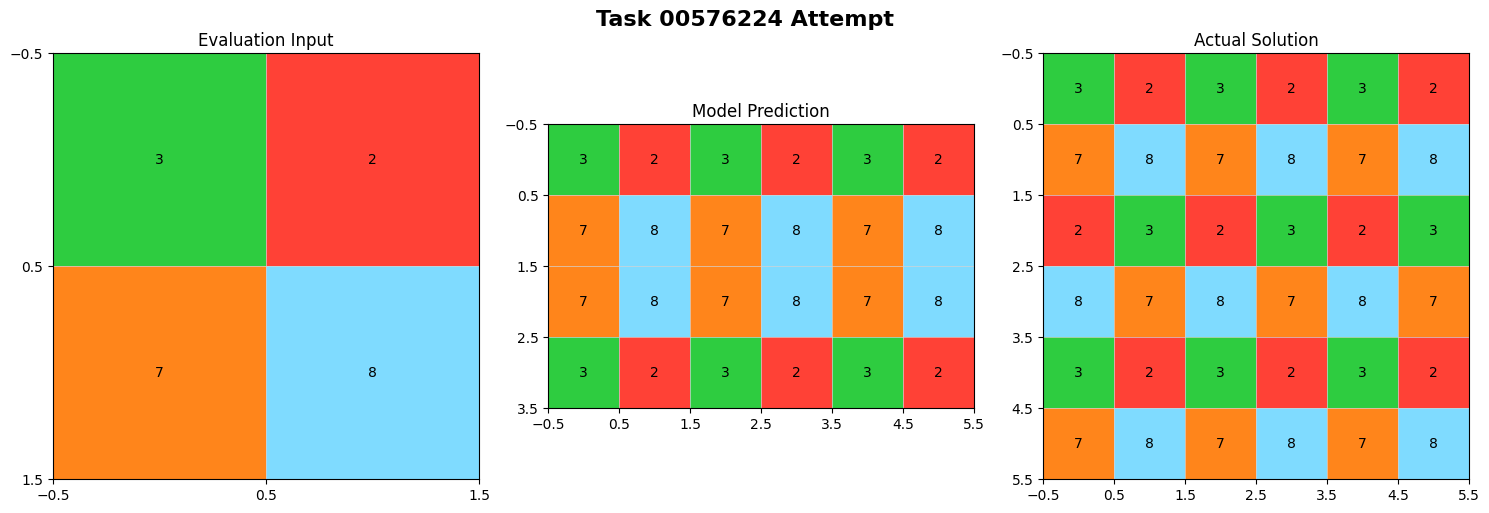


Prediction details for attempt_1, retry 0:
Prediction: [[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [7, 8, 7, 8, 7, 8], [3, 2, 3, 2, 3, 2]]
Expected solution: [[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [2, 3, 2, 3, 2, 3], [8, 7, 8, 7, 8, 7], [3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8]]
2024-11-11 12:16:28,171 - INFO - Plot flag for task 00576224, attempt 2, retry 0: True
2024-11-11 12:16:28,173 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[8, 6],
[6, 4],]

Example 1: Output
[
[8, 6, 8, 6, 8, 6],
[6, 4, 6, 4, 6, 4],
[6, 8, 6, 8, 6, 8],
[4, 6, 4, 6, 4, 6],
[8, 6, 8, 6, 8, 6],
[6, 4, 6, 4, 6, 4],]

Example 2: Input
[
[7, 9],
[4, 3],]

Example 2: Output
[
[7, 9, 7, 9, 7, 9],
[4, 3, 4, 3, 4, 3],
[9, 7, 9, 7, 9, 7],
[3, 4, 3, 4, 3, 4],
[7, 9, 7, 9, 7, 9],
[4, 3, 4, 3, 4, 3],]

Test
[
[3, 2]
[7, 8]]

Your Response: with predicted grid size: 6x6
Debug - Plotting dimensions:
Test input shape: (2, 2)
Predicted solution shape: (2, 6, 2)
Actual solution shape: (6, 6)
2024-11-11 

In [138]:
main(task_set='evaluation', NUM_TASKS=1)